In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_preprocessing.image import img_to_array
import numpy as np
import cv2
import tensorflow as tf

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode='nearest',
                                   validation_split=0.25)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('./custom_dataset/',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode = 'grayscale')

test_set = test_datagen.flow_from_directory('./test_dataset/',
                                            target_size = (64, 64),
                                            batch_size = 128,
                                            class_mode = 'categorical',
                                            color_mode = 'grayscale')

validation_set = train_datagen.flow_from_directory('./custom_dataset/',
                                                   target_size = (64,64),
                                                   batch_size = 64,
                                                   class_mode = 'categorical',
                                                   color_mode = 'grayscale',
                                                   subset="validation",
                                                   shuffle=True)

Found 12265 images belonging to 6 classes.
Found 308 images belonging to 3 classes.
Found 3065 images belonging to 6 classes.


In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 6, activation = 'softmax'))  # 6 classes for 6 gestures
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

In [5]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
             ModelCheckpoint(filepath='saved_models/hand_classifier.h5', save_best_only=True)]

model.fit(training_set,
          epochs = 25,
          validation_data = validation_set,
          callbacks = callbacks)


Epoch 1/25
384/384 [==============================] - 79s 204ms/step - loss: 0.6592 - accuracy: 0.7517 - val_loss: 0.1579 - val_accuracy: 0.9468
Epoch 2/25
384/384 [==============================] - 28s 74ms/step - loss: 0.2361 - accuracy: 0.9157 - val_loss: 0.0619 - val_accuracy: 0.9824
Epoch 3/25
384/384 [==============================] - 30s 78ms/step - loss: 0.1531 - accuracy: 0.9456 - val_loss: 0.0304 - val_accuracy: 0.9912
Epoch 4/25
384/384 [==============================] - 31s 82ms/step - loss: 0.1208 - accuracy: 0.9561 - val_loss: 0.0229 - val_accuracy: 0.9941
Epoch 5/25
384/384 [==============================] - 31s 80ms/step - loss: 0.0982 - accuracy: 0.9653 - val_loss: 0.0161 - val_accuracy: 0.9964
Epoch 6/25
384/384 [==============================] - 31s 82ms/step - loss: 0.0812 - accuracy: 0.9709 - val_loss: 0.0129 - val_accuracy: 0.9967
Epoch 7/25
384/384 [==============================] - 32s 83ms/step - loss: 0.0773 - accuracy: 0.9735 - val_loss: 0.0120 - val_accuracy

In [6]:
model.save('saved_models/hand_classifier1.h5')

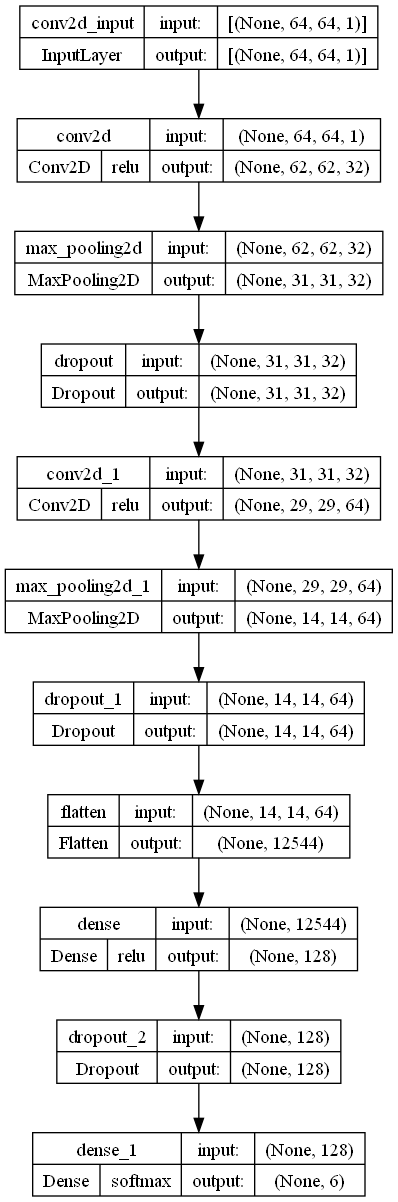

In [7]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)


In [8]:
actions = {
0:"click_right",
1:"click_left",
2:"scroll_down",
3:"double_click",
4:"scroll_up",
5:"move",
}
def get_prediction(img):
    for_pred = cv2.resize(img,(64,64))
    x = img_to_array(for_pred)
    x = x/255.0
    x = x.reshape((1,) + x.shape)
    pred = str(actions[np.argmax(model.predict(x))])
    print(pred)
    return pred


In [15]:
def get_test_prediction(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    for_pred = cv2.resize(img,(64,64))
    x = img_to_array(for_pred)
    x = x/255.0
    x = x.reshape((1,) + x.shape)
    pred = str(actions[np.argmax(model.predict(x))])
    print(pred)
    return pred

# Test the function
get_test_prediction('test_dataset/0/img801.jpg')
get_test_prediction('test_dataset/1/img575.jpg')
get_test_prediction('test_dataset/2/img739.jpg')

1/1 [==============================] - 0s 57ms/step
scroll_up
1/1 [==============================] - 0s 17ms/step
click_left
1/1 [==============================] - 0s 19ms/step
scroll_down


'scroll_down'

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
model = tf.keras.models.load_model('saved_models/hand_classifier1.h5')
Y_pred = model.predict(validation_set)

y_pred = np.argmax(Y_pred, axis=1)


print('Classification Report')
target_names = list(validation_set.class_indices.keys())  # get the class labels
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

48/48 [==============================] - 4s 82ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.17      0.17      0.17       504
           1       0.19      0.19      0.19       504
           2       0.17      0.17      0.17       509
           3       0.19      0.19      0.19       535
           4       0.16      0.16      0.16       505
           5       0.18      0.18      0.18       508

    accuracy                           0.18      3065
   macro avg       0.18      0.18      0.18      3065
weighted avg       0.18      0.18      0.18      3065



In [14]:
Y_pred

array([[4.55587525e-07, 5.30204396e-08, 9.99780595e-01, 2.18832240e-04,
        2.61595967e-09, 1.60497830e-11],
       [2.89411341e-31, 2.02044082e-30, 0.00000000e+00, 1.57914914e-30,
        2.85534698e-13, 1.00000000e+00],
       [2.41640583e-17, 1.55475524e-12, 8.74126950e-17, 1.00000000e+00,
        9.56537904e-11, 1.08422999e-18],
       ...,
       [1.59045205e-25, 1.04296196e-22, 7.89880906e-21, 2.45714062e-07,
        9.99999762e-01, 1.93945896e-14],
       [4.62285883e-04, 9.99537468e-01, 1.90222750e-07, 1.09631685e-07,
        5.40519123e-11, 7.13037311e-12],
       [1.90111544e-13, 4.87610237e-14, 7.15480433e-22, 1.33398304e-14,
        1.01865953e-06, 9.99998927e-01]], dtype=float32)